<a href="https://colab.research.google.com/github/music-ai-644/AI_Study_2022/blob/main/Quiz/220721_%EC%B5%9C%EB%B3%B4%EA%B2%BD_week8_quiz_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [388]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np 

In [389]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [390]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


In [391]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] #인덱스별 네이밍리스트

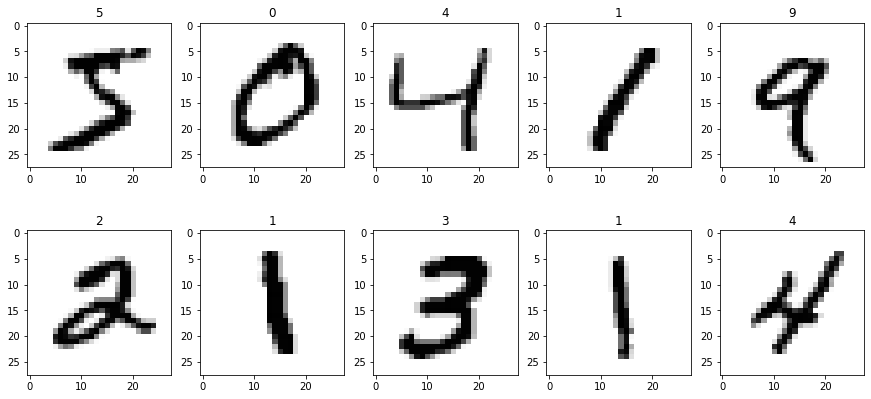

In [392]:
fig = plt.figure(figsize=(15, 7)) #잘 나오는지확인하는 과정

for i in range(10):
    plottable_image = np.reshape(x_train[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_train[i]])
    ax.imshow(plottable_image, cmap='gray_r')

In [393]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42) #테스트는 20퍼센트비율

In [394]:
x_train = x_train / 255
x_valid = x_valid / 255 
x_test = x_test / 255

In [395]:
np.bincount(y_train)

array([4738, 5394, 4766, 4905, 4674, 4337, 4734, 5012, 4681, 4759])

In [396]:
np.bincount(y_valid)

array([1185, 1348, 1192, 1226, 1168, 1084, 1184, 1253, 1170, 1190])

In [397]:
x_train_reshape = x_train.reshape(-1, 784)
x_valid_reshape = x_valid.reshape(-1, 784)
x_test_reshape = x_test.reshape(-1, 784)

print("학습 데이터 셋의 형태 : ", x_train_reshape.shape) #60000개의 데이터 중 80퍼센트
print("검증 데이터 셋의 형태 : ", x_valid_reshape.shape) #60000개의 데이터 중 20퍼센트

학습 데이터 셋의 형태 :  (48000, 784)
검증 데이터 셋의 형태 :  (12000, 784)


In [398]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [399]:
y_train_encoded = tf.keras.utils.to_categorical(y_train) #원핫 인코딩
y_valid_encoded = tf.keras.utils.to_categorical(y_valid)

In [400]:
print(y_train[0], y_train_encoded[0], class_names[y_train[0]]) #인덱스가 제대로 일치하는지 확인

1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1


In [401]:
import torch
x_train_torch = torch.FloatTensor(x_train_reshape)
y_train_torch = torch.FloatTensor(y_train_encoded)
x_valid_torch = torch.FloatTensor(x_valid_reshape)
y_valid_torch = torch.FloatTensor(y_valid_encoded) 
x_test_torch = torch.FloatTensor(x_test_reshape)
y_test_torch = torch.FloatTensor(y_test)

In [402]:
cuda_ = torch.cuda.is_available()
device = torch.device("cuda" if cuda_ else "cpu")
print(device)

cuda


In [403]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [404]:
class FigureDataset(Dataset):
  def __init__(self, x, y):
    self.x_data = x
    self.y_data = y
  
  def __getitem__(self, index):
    x = self.x_data[index]
    y = self.y_data[index]
    return x, y
    
  def collate_fn(self, batch):
    x, y = zip(*batch)
    return x, y

  def __len__(self):
    return len(self.x_data)

In [405]:
dataset = FigureDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [406]:
for b in dataloader:
    x_batch=b[0]
    y_batch=b[1]
    print("배치사이즈:", len(x_batch))
    print("데이터 크기:", (x_batch.size()))
    print("타겟 크기:", (y_batch.size()))
    break

배치사이즈: 32
데이터 크기: torch.Size([32, 784])
타겟 크기: torch.Size([32, 10])


In [407]:
from tqdm import tqdm 
import random 

random_seed = 100000
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

model = nn.Sequential(
    nn.Linear(784, 392),
    nn.ReLU(),
    nn.Linear(392, 196),
    nn.ReLU(),
    nn.Linear(196, 10),
    nn.Softmax(dim=1),
    )

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

global_step = 0 
for epoch in range(20):
  t = tqdm(dataloader, ncols=100)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    output = model(x_batch)
    loss = criterion(output, y_batch)
    model.zero_grad() 
    optim.zero_grad()
    loss.backward()
    optim.step() 

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))

  predicts = model(x_valid_torch)
  predicts = torch.argmax(predicts, 1)

  correct = 0 
  for i in range(len(predicts)):
    if predicts[i].item() == y_valid[i]:
      correct += 1
  acc = correct / len(predicts)
  print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))

epoch: 1 | global_step:     1500 | loss: 1.5621: 100%|█████████| 1500/1500 [00:13<00:00, 112.50it/s]


epoch: 1 | global_step: 1500 | valid acc: 90.916667%


epoch: 2 | global_step:     3000 | loss: 1.4747: 100%|█████████| 1500/1500 [00:13<00:00, 107.33it/s]


epoch: 2 | global_step: 3000 | valid acc: 92.091667%


epoch: 3 | global_step:     4500 | loss: 1.5274: 100%|█████████| 1500/1500 [00:13<00:00, 107.26it/s]


epoch: 3 | global_step: 4500 | valid acc: 92.983333%


epoch: 4 | global_step:     6000 | loss: 1.4672: 100%|██████████| 1500/1500 [00:16<00:00, 91.32it/s]


epoch: 4 | global_step: 6000 | valid acc: 93.466667%


epoch: 5 | global_step:     7500 | loss: 1.4965: 100%|█████████| 1500/1500 [00:14<00:00, 100.19it/s]


epoch: 5 | global_step: 7500 | valid acc: 94.016667%


epoch: 6 | global_step:     9000 | loss: 1.4910: 100%|█████████| 1500/1500 [00:14<00:00, 105.61it/s]


epoch: 6 | global_step: 9000 | valid acc: 94.575000%


epoch: 7 | global_step:    10500 | loss: 1.5628: 100%|█████████| 1500/1500 [00:13<00:00, 107.39it/s]


epoch: 7 | global_step: 10500 | valid acc: 94.891667%


epoch: 8 | global_step:    12000 | loss: 1.4664: 100%|█████████| 1500/1500 [00:14<00:00, 105.19it/s]


epoch: 8 | global_step: 12000 | valid acc: 94.891667%


epoch: 9 | global_step:    13500 | loss: 1.4937: 100%|█████████| 1500/1500 [00:14<00:00, 105.22it/s]


epoch: 9 | global_step: 13500 | valid acc: 95.508333%


epoch: 10 | global_step:    15000 | loss: 1.4624: 100%|████████| 1500/1500 [00:14<00:00, 104.60it/s]


epoch: 10 | global_step: 15000 | valid acc: 95.550000%


epoch: 11 | global_step:    16500 | loss: 1.4956: 100%|████████| 1500/1500 [00:14<00:00, 105.91it/s]


epoch: 11 | global_step: 16500 | valid acc: 95.933333%


epoch: 12 | global_step:    18000 | loss: 1.4827: 100%|████████| 1500/1500 [00:14<00:00, 102.56it/s]


epoch: 12 | global_step: 18000 | valid acc: 96.050000%


epoch: 13 | global_step:    19500 | loss: 1.4930: 100%|████████| 1500/1500 [00:14<00:00, 101.37it/s]


epoch: 13 | global_step: 19500 | valid acc: 96.158333%


epoch: 14 | global_step:    21000 | loss: 1.4634: 100%|████████| 1500/1500 [00:14<00:00, 105.33it/s]


epoch: 14 | global_step: 21000 | valid acc: 96.366667%


epoch: 15 | global_step:    22500 | loss: 1.5042: 100%|████████| 1500/1500 [00:14<00:00, 102.77it/s]


epoch: 15 | global_step: 22500 | valid acc: 96.433333%


epoch: 16 | global_step:    24000 | loss: 1.4954: 100%|████████| 1500/1500 [00:14<00:00, 104.01it/s]


epoch: 16 | global_step: 24000 | valid acc: 96.558333%


epoch: 17 | global_step:    25500 | loss: 1.5512: 100%|████████| 1500/1500 [00:14<00:00, 103.57it/s]


epoch: 17 | global_step: 25500 | valid acc: 96.658333%


epoch: 18 | global_step:    27000 | loss: 1.4635: 100%|████████| 1500/1500 [00:14<00:00, 100.45it/s]


epoch: 18 | global_step: 27000 | valid acc: 96.700000%


epoch: 19 | global_step:    28500 | loss: 1.4625: 100%|████████| 1500/1500 [00:14<00:00, 106.25it/s]


epoch: 19 | global_step: 28500 | valid acc: 97.041667%


epoch: 20 | global_step:    30000 | loss: 1.4969: 100%|████████| 1500/1500 [00:14<00:00, 106.36it/s]


epoch: 20 | global_step: 30000 | valid acc: 96.841667%


In [417]:
predict = model(x_test_torch)
predict = torch.argmax(predict, 1)

In [409]:
correct = 0 
for i in range(len(predict)):
  if predict[i].item() == y_test[i]:
    correct += 1
acc = correct/len(predict)
print("Test accuracy : {:.2%}".format(acc))

Test accuracy : 96.94%


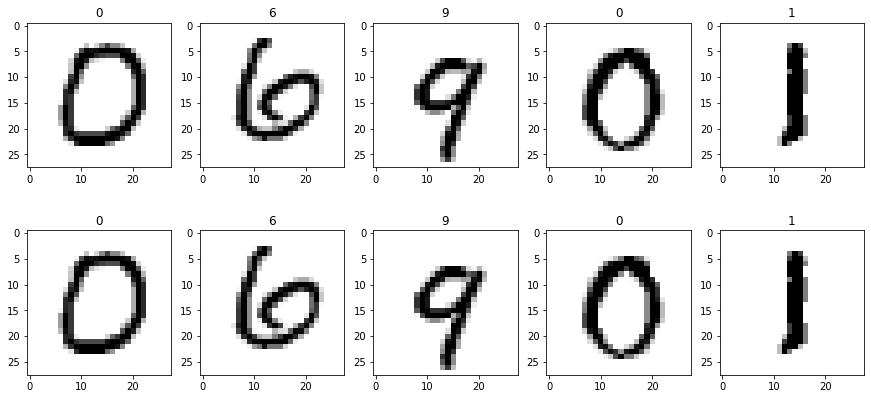

In [423]:
fig = plt.figure(figsize=(15, 7))

for i in range(5):
    plottable_image = x_test[i+10]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_test[i+10]])
    ax.imshow(plottable_image, cmap='gray_r')
  
for i in range(5):
    plottable_image = x_test[i+10]
    ax = fig.add_subplot(2, 5, i+6)
    ax.title.set_text(class_names[predict[i+10].item()])
    ax.imshow(plottable_image, cmap='gray_r')

plt.show()